# Model Building - Get Pretrained Network

Import packages

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

download pretrained network

In [2]:
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

feature_map = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                           include_top=False,
                           weights='imagenet')

feature_vec_base = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                           include_top=True,
                           weights='imagenet')
feature_vec_base.trainable = False
feature_map.trainable = False

Remove the top probability layer on feature vector base model

In [3]:
layer_name = "avg_pool"
feature_vec_model = tf.keras.Model(inputs=feature_vec_base.input, outputs=feature_vec_base.get_layer(layer_name).output, name="resnet50_base")

In [4]:
feature_vec_model.summary()

Model: "resnet50_base"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________

Add 2 layers of feed forward neural net on feature vector base model

In [5]:
NUM_UNITS = 200
dense_1 = tf.keras.layers.Dense(NUM_UNITS, activation="relu", name="style_embedding_1")
dense_2 = tf.keras.layers.Dense(NUM_UNITS,  name="style_embedding_2")

feature_vec_model = tf.keras.Sequential([feature_vec_model, dense_1, dense_2])

feature_vec_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50_base (Model)        (None, 2048)              23587712  
_________________________________________________________________
style_embedding_1 (Dense)    (None, 200)               409800    
_________________________________________________________________
style_embedding_2 (Dense)    (None, 200)               40200     
Total params: 24,037,712
Trainable params: 450,000
Non-trainable params: 23,587,712
_________________________________________________________________


In [6]:
len(feature_vec_model.trainable_variables)

4

2 layers + 2 bias

## Test with image

Format Image

In [7]:
IMG_SIZE = 224 # All images will be resized to 224 x 224

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [8]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [9]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

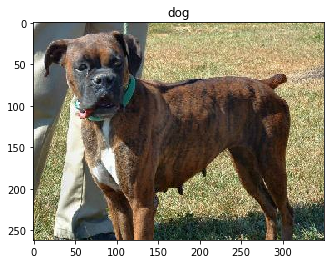

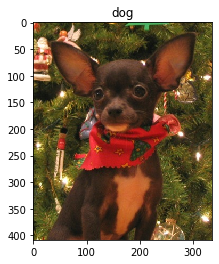

In [10]:
import matplotlib.pyplot as plt
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

In [11]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [12]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [13]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 224, 224, 3])

## create an image batch with the complete the look 

In [14]:
import os
training_data_dir = "../data/processed/training/fashion_scene/*"
training_label_dir = "../data/processed/training/fashion_product/*"

In [15]:
list_ds = tf.data.Dataset.list_files(str(training_data_dir)).repeat(3)

In [16]:
for f in list_ds.take(5):
      print(f.numpy())

b'../data/processed/training/fashion_scene/934d8a5a6bd0e8949af9cf899b8d8a9a_8812efcb4f0f70fe5368a59246227542.jpg'
b'../data/processed/training/fashion_scene/00989b1a13ec7d7c713521463dc041aa_1aa7a5536c1523f5e0a1c9da31e3a821.jpg'
b'../data/processed/training/fashion_scene/bd825971583df9ecc93c913f054d244a_c62a1b4ac309280cf4907e13b3fd8fa3.jpg'
b'../data/processed/training/fashion_scene/958a708e5a9f8249e938689180f09df8_0a80ceebfe0f8934ff693a5e0f916a50.jpg'
b'../data/processed/training/fashion_scene/1c63eb1d9c911032e888da9bcfaac583_b5d102717c9a75832741599c3d2b9ac8.jpg'


In [17]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # string before .jpg, after _ is the label
    file_name = tf.strings.split(parts[-1], "_")
    label_name = tf.strings.split(file_name[1], ".")[0]
    return label_name

In [18]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return img

In [19]:
def rotate(x: tf.Tensor) -> tf.Tensor:
    """Rotation augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """

    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(x, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))


In [20]:
def flip(x: tf.Tensor) -> tf.Tensor:
    """Flip augmentation

    Args:
        x: Image to flip

    Returns:
        Augmented image
    """
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)

    return x

In [21]:
def color(x: tf.Tensor) -> tf.Tensor:
    """Color augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """
    x = tf.image.random_hue(x, 0.08)
    x = tf.image.random_saturation(x, 0.6, 1.6)
    x = tf.image.random_brightness(x, 0.05)
    x = tf.image.random_contrast(x, 0.7, 1.3)

    return x

In [22]:
def zoom(x: tf.Tensor) -> tf.Tensor:
    """Zoom augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """

    # Generate 20 crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(0.8, 1.0, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize(
            [img], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=(32, 32)
        )
        # Return a random crop
        return crops[
            tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)
        ]

    choice = tf.random.uniform(shape=[], minval=0.0, maxval=1.0, dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: x, lambda: random_crop(x))

In [23]:
def process_image(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    augmentations = [flip, color, zoom,rotate]
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    applied_f = augmentations[np.random.choice(len(augmentations), 1)[0]]
    img = tf.cond(
        tf.random.uniform([], 0, 1) > 0.75, lambda: applied_f(img), lambda: img
        )
    return img, label

In [24]:
labeled_data_training = list_ds.map(lambda x: process_image(x), num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [25]:
labeled_data_training

<ParallelMapDataset shapes: ((None, None, 3), ()), types: (tf.float32, tf.string)>

In [26]:
for image, label in labeled_data_training.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  b'b86d7c788c203a28af87f82c1be0ab5a'
Image shape:  (224, 224, 3)
Label:  b'4f56fac3dfb8bec91bc564f9cbd816ec'
Image shape:  (224, 224, 3)
Label:  b'd95ef8023f9c04968e3a6efce85742a6'
Image shape:  (224, 224, 3)
Label:  b'e7d70ce42ca57182c097ebd64f7ba91f'
Image shape:  (224, 224, 3)
Label:  b'22a5804e7c8a3327b91afb19d64fc043'


In [27]:
def plot_images(dataset, n_images):
    output = np.zeros((224, 1, 3))

    row = 0
    for images, label in dataset.take(n_images):
        output = np.concatenate((output, images.numpy()), axis=1)
        row += 1

    plt.figure(figsize=(25, 10))
    plt.imshow(output)
    plt.show()


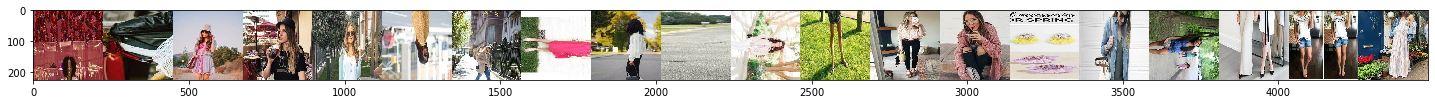

In [30]:
plot_images(labeled_data_training, n_images=20)